## Genome

In [33]:
from typing import List, Dict
import random

class NeuronGene:
    def __init__(self, neuron_id: int, ntype: str = "hidden", bias: float = 0, activation: str = "relu") -> None:
        self.neuron_id = neuron_id
        self.type = ntype # input | output | hidden
#         self.bias = bias
        self.bias = 0
        self.activation = activation
        
    def __str__(self) -> str:
        return f"NeuronGene: {self.neuron_id}\n    Type: {self.type}\n    Bias: {self.bias}\n    Activation: {self.activation}"
        
class LinkGene:
    def __init__(self, input_id: int, output_id: int, weight: float = 0, is_enabled: bool = True) -> None:
        self.input_id = input_id
        self.output_id = output_id
        self.weight = weight
        self.is_enabled = is_enabled
        
    def __str__(self) -> str:
        return f"NeuronGene:\n    input_id: {self.input_id}\n    output_id: {self.output_id}\n    weight: {self.weight}\n    is_enabled: {self.is_enabled}"
        
class Genome:
    def __init__(self, genome_id: int, num_inputs: int, num_outputs: int) -> None:
        self.genome_id = genome_id
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.neurons = []
        self.links = []
        
    def add_neuron(self, neuron: NeuronGene) -> None:
        self.neurons.append(neuron)
        
    def add_link(self, link: LinkGene) -> None:
        self.links.append(link)
        
    def make_input_ids(self) -> List[int]:
        return [n.neuron_id for n in self.neurons if n.type == "input"]
    
    def make_output_ids(self) -> List[int]:
        return [n.neuron_id for n in self.neurons if n.type == "output"]
    
    def __str__(self) -> str:
        input_neurons = len([n.neuron_id for n in self.neurons if n.type == "input"])
        output_neurons = len([n.neuron_id for n in self.neurons if n.type == "output"])
        hidden_neurons = len([n.neuron_id for n in self.neurons if n.type == "hidden"])
        num_links = len(self.links)
        return f"Genome: {self.genome_id}\n    input neurons: {input_neurons}\n    output neurons: {output_neurons}\n    hidden neurons: {hidden_neurons}\n    num links: {num_links}"
        
class Individual:
    def __init__(self, genome: Genome, fitness: float) -> None:
        self.genome = genome
        self.fitness = fitness

## Crossover

In [34]:
def crossover_neuron(gene1: NeuronGene, gene2: NeuronGene) -> NeuronGene:
    # Ensure the crossover occurs between neurons of the same type from two individuals
    assert(gene1.neuron_id == gene2.neuron_id)
    assert(gene1.type == gene2.type)
    neuron_id = gene1.neuron_id
    # Randomly choose the bias and activations from either of the parents
    bias = random.choice([gene1.bias, gene2.bias])
    activation = random.choice([gene1.activation, gene2.activation])
    return NeuronGene(neuron_id, gene1.type, bias, activation)

def crossover_link(gene1: LinkGene, gene2: LinkGene) -> LinkGene:
    # Ensure the crossover occurs between neurons of the same type from two individuals
    assert(gene1.input_id == gene2.input_id)
    assert(gene1.output_id == gene2.output_id)
    input_id = gene1.input_id
    output_id = gene2.output_id
    # Randomly choose the bias and activations from either of the parents
    weight = random.choice([gene1.weight, gene2.weight])
    is_enabled = random.choice([gene1.is_enabled, gene2.is_enabled])
    return LinkGene(input_id, output_id, weight, is_enabled)

def crossover(dominant: Individual, recessive: Individual, genome_id: int) -> Genome:
    
    offspring = Genome(genome_id, dominant.genome.num_inputs, dominant.genome.num_outputs)
    
    # Inherit neuron gene
    for dominant_neuron in dominant.genome.neurons:
        
        neuron_id = dominant_neuron.neuron_id
        recessive_neuron = next((neuron for neuron in recessive.genome.neurons if neuron.neuron_id == neuron_id), None)
        
        if recessive_neuron:
            offspring.neurons.append(crossover_neuron(dominant_neuron, recessive_neuron))
        else:
            offspring.neurons.append(dominant_neuron)
            
    # Inherit link gene
    for dominant_link in dominant.genome.links:
        
        input_id = dominant_link.input_id
        output_id = dominant_link.output_id
        recessive_link = next((link for link in recessive.genome.links if ((link.input_id == input_id) and (link.output_id == output_id))), None)
        
        if recessive_link:
            offspring.links.append(crossover_link(dominant_link, recessive_link))
        else:
            offspring.links.append(dominant_link)
            
    return offspring

# Test crossover_neuron
# neuron_gene1 = NeuronGene(1, -1, "Relu")
# neuron_gene2 = NeuronGene(1, 1, "Tanh")
# print(neuron_gene1)
# print(neuron_gene2)
# child_neuron_gene = crossover_neuron(neuron_gene1, neuron_gene2)
# print(child_neuron_gene)

# Test crossover_link
# link_gene1 = LinkGene(4, 8, 0.8, True)
# link_gene2 = LinkGene(4, 8, -7.38, False)
# print(link_gene1)
# print(link_gene2)
# child_link_gene = crossover_link(link_gene1, link_gene2)
# print(child_link_gene)

# Test crossover
# genome1 = NeuronGene(1, -1, "Relu")
# neuron_gene2 = NeuronGene(1, 1, "Tanh")
# print(neuron_gene1)
# print(neuron_gene2)
# child_neuron_gene = crossover_neuron(neuron_gene1, neuron_gene2)
# print(child_neuron_gene)

## Mutation

In [35]:
import random

"""
There are 4 types of structural mutations that can occur in the genome
- Add a link between two neuron (`mutate_add_link`)
- Remove a link between two neurons (`mutate_remove_link`)
- Add a new hidden neuron (`mutate_add_neuron`)
- Remove a hidden neuron (`mutate_remove_neuron`)

Non structural mutations occur by randomly changing properties of the link or neuron

To Do:
- [*] create a function `would_create_cycle` for checking cycles
    No need for cycle checking as the new implementation uses an iterative graph traversal
- [*] create a link mutator object `link_mutator` for generating new weights smartly
    Creating new weights using the `new_value` function of `population` class
- [ ] create a neuron mutator object `neuron_mutator` for generating new neurons smartly
"""

"""
    Structural Mutations
"""

def mutate_add_link(genome: Genome, weight: float) -> None:
    """
        Adds a new link to the genome (or enables an existing one), ensuring no cycles

        Args:
        genome: The genome to mutate.
    """

    input_id = random.choice([n.neuron_id for n in genome.neurons if n.type != "output"])
    output_id = random.choice([n.neuron_id for n in genome.neurons if n.type != "input"])

    # Check for existing link
    for link in genome.links:
        if link.input_id == input_id and link.output_id == output_id:
            link.is_enabled = True  # Enable if found
            return

    # Assuming you have a 'link_mutator' object for generating new weights
#     weight = link_mutator.new_value(input_id, output_id)
    new_link = LinkGene(input_id, output_id, weight, True)  # Enabled by default
    genome.links.append(new_link)

def mutate_remove_link(genome: Genome):
    """
        Removes a randomly choosen link from the genome

        Args:
        genome: The genome to mutate.
    """

    # Check if there are any links to remove
    if len(genome.links) == 0:
        return
    
    link = random.choice(genome.links)
    genome.links.remove(link)
    
def mutate_add_neuron(genome: Genome, bias: float = 0, activation: str = "relu"):
    """
        Adds a new neuron to the genome by splitting a random link.

        Args:
        genome: The genome to mutate.
    """

    # Check if there are any links to split
    if len(genome.links) == 0:
        return

    # Choose a random link to split
    link_to_split = random.choice(genome.links)
    link_to_split.is_enabled = False  # Disable the chosen link

    # Create a new neuron
#     new_neuron = neuron_mutator.new_neuron()
    new_neuron = NeuronGene(len(genome.neurons), "hidden", bias, activation)  # Assuming bias and activation logic
    genome.neurons.append(new_neuron)

    # Create new links from the split point to the new neuron and the original output
    genome.links.append(LinkGene(link_to_split.input_id, new_neuron.neuron_id, 1, True))
    genome.links.append(LinkGene(new_neuron.neuron_id, link_to_split.output_id, link_to_split.weight, True))
    
def mutate_remove_neuron(genome: Genome):
    """
        Removes a randomly chosen hidden neuron from the genome and removes associated links.

        Args:
        genome: The genome to mutate.
    """
    
    hidden_neurons = [n for n in genome.neurons if n.type == "hidden"]
    if len(hidden_neurons) == 0:
        return

    # Choose a random hidden neuron
    neuron_to_remove = random.choice(hidden_neurons)

    # Remove associated links
    links_to_remove = [
        link for link in genome.links if ((link.input_id == neuron_to_remove.neuron_id) and (link.output_id == neuron_to_remove.neuron_id))
    ]
    for link in links_to_remove:
        genome.links.remove(link)

    # Remove the neuron itself
    genome.neurons.remove(neuron_to_remove)

## Neural Network

In [36]:
from collections import deque
import numpy as np
import random
import math

class Node:
    def __init__(self, node_id: int, ntype: str, bias: float, activation: str) -> None:
        self.node_id = node_id
        self.type = ntype
        self.bias = bias
        self.activation = activation
        self.inputs = []
        self.outputs = []
        self.value = None
        
    def add_input(self, input_id, weight) -> None:
        self.inputs.append((input_id, weight))
        
    def add_output(self, output_id, weight) -> None:
        self.outputs.append((output_id, weight))

class Graph:
    def __init__(self, genome: Genome):
        
        self.genome = genome
        self.nodes = dict()
        
        for n in genome.neurons:
            self.nodes[n.neuron_id] = Node(n.neuron_id, n.type, n.bias, n.activation)
            
        for link in genome.links:
            input_id = link.input_id
            output_id = link.output_id
            weight = link.weight
            
            if link.is_enabled:
                self.nodes[input_id].add_output(output_id, weight)
                self.nodes[output_id].add_input(input_id, weight)
            
    def forward(self, inputs: List[float], verbose: bool = False) -> List[float]:
        
        input_ids = self.genome.make_input_ids()
        output_ids = self.genome.make_output_ids()
        neurons = self.genome.neurons

        neuron_queue = deque(input_ids)
        
        assert (len(inputs) == len(input_ids)), f"Size of input should match the size of input neurons in genome, Size of input: {len(inputs)}, Size of input neurons: {len(input_ids)}"
        
        for value, input_id in zip(inputs, input_ids):
            self.nodes[input_id].value = value
        
        if verbose:
            num_iter = 0
            max_len = 0
        while len(neuron_queue):
            
            nid = neuron_queue.popleft()
            node = self.nodes[nid]
            
            status = self.node_pass(node)
            
            for (output_id, weight) in node.outputs:
                if self.nodes[output_id].value == None:
                    neuron_queue.append(output_id)
                    
            if not status:
                neuron_queue.append(nid)
            
            if verbose:
                max_len = max(max_len, len(neuron_queue))
                num_iter += 1
            
        outputs = []
        for output_id in output_ids:
            value = self.nodes[output_id].value
            assert(value != None)
            outputs.append(value)
        
        if verbose:
            print(f"Num iterations: {num_iter}")
            print(f"Max Queue len: {max_len}")
            
        return outputs
            
    def node_pass(self, node):
        
        if node.type != "input" and node.value == None:
            
            value = 0
            for (input_id, weight) in node.inputs:
                input_value = self.nodes[input_id].value
                if input_value == None:
                    return False
                value += input_value * weight
            value += node.bias
            value = self.activate(value, node.activation)
            node.value = value
            
        return True
                    
    def activate(self, x: int, activation: str, alpha: float = 0.01) -> float:
        
        if activation == "sigmoid":
            return 1 / (1 + math.exp(-x))
        elif activation == "tanh":
            return math.tanh(x)
        elif activation == "relu":
            return max(x, 0)
        elif activation == "leaky_relu":
            return max(alpha * x, x)
        else:
            raise Exception("Undefined activation function")

num_inputs = 100
num_outputs = 1
genome = Genome(0, num_inputs, num_outputs)

for neuron_id in range(-num_inputs, 0):
    genome.add_neuron(NeuronGene(neuron_id, "input"))

for neuron_id in range(num_outputs):
    genome.add_neuron(NeuronGene(neuron_id, "output"))

for input_id in range(-num_inputs, 0):
    for output_id in range(num_outputs):
        genome.add_link(LinkGene(input_id, output_id))
        
print(genome)
            
graph = Graph(genome)
inputs = np.random.randn(num_inputs)
outputs = graph.forward(inputs, True)

Genome: 0
    input neurons: 100
    output neurons: 1
    hidden neurons: 0
    num links: 100
Num iterations: 200
Max Queue len: 100


## Simulation

In [37]:
import matplotlib.pyplot as plt
from typing import List
import random
import copy

"""
To Do
- [ ] Smartly initialize the network weights
- [ ] While choosing random parents ensure that we don't take a single individual twice
"""

class Population:
    def __init__(self, config):
        self.config = config
        self.individuals = []
        self.genome_counter = 0

        for _ in range(self.config.population_size):
            self.individuals.append(Individual(self.new_genome(), self.config.kFitnessNotComputed))
            
    def next_genome_id(self):
        self.genome_counter += 1
        return self.genome_counter - 1

    def new_genome(self):

        genome = Genome(self.next_genome_id(), self.config.num_inputs, self.config.num_outputs)
        
        for neuron_id in range(-self.config.num_inputs, 0):
            genome.add_neuron(NeuronGene(neuron_id, "input", self.new_value()))

        for neuron_id in range(self.config.num_outputs):
            genome.add_neuron(NeuronGene(neuron_id, "output", self.new_value()))

        for input_id in range(-self.config.num_inputs, 0):
            for output_id in range(self.config.num_outputs):
                genome.add_link(LinkGene(input_id, output_id, self.new_value()))

        return genome
    
    def run(self) -> Individual:
        
        self.history = []
        
        pbar = tqdm(range(self.config.num_generations))
        for _ in pbar:
            
            info = self.config.compute_fitness(self.individuals)
            avg_score = info["avg_scores"]
            pbar.set_description(f"Avg Score: {avg_score}")
#             self.update_best()
            self.individuals = self.reproduce()
    
            self.history.append(info)
        
        return self.individuals
    
    def reproduce(self) -> List[Individual]:
        
        # sort individuals by fitness
        old_members = sorted(self.individuals, key= lambda x: x.fitness, reverse=True)
        reproduction_cutoff = int(self.config.survival_threshold * len(old_members))
        old_members = old_members[:reproduction_cutoff]
        
        new_generation = []
        spawn_size = self.config.population_size
        while spawn_size >= 0:
            
            parent1 = random.choice(old_members)
            parent2 = random.choice(old_members)

            offspring = crossover(copy.deepcopy(parent1), copy.deepcopy(parent2), self.next_genome_id())
#             self.mutate(offspring)
            new_generation.append(Individual(offspring, self.config.kFitnessNotComputed))
            
            spawn_size -= 1
        
        return new_generation
    
    def mutate(self, genome: Genome):
        
        if random.random() < self.config.prob_add_link:
            mutate_add_link(genome, self.new_value())

        if random.random() < self.config.prob_remove_link:
            mutate_remove_link(genome)
            
        if random.random() < self.config.prob_add_neuron:
            mutate_add_neuron(genome)
        
        if random.random() < self.config.prob_remove_neuron:
            mutate_remove_neuron(genome)
            
        for link in genome.links:
            if random.random() < self.config.mutation_rate:
                link.weight = self.mutate_delta(link.weight)
            
    def new_value(self):
        return self.clamp(random.gauss(self.config.init_mean, self.config.init_stdev))

    def mutate_delta(self, value):
        delta = self.clamp(random.gauss(0.0, self.config.mutate_power))
        return self.clamp(value + delta)

    def clamp(self, x):
        return min(self.config.max, max(self.config.min, x))
    
    def plot(self):
        max_scores = [info["max_scores"] for info in self.history]
        avg_scores = [info["avg_scores"] for info in self.history]
        min_scores = [info["min_scores"] for info in self.history]
        
        # Creating a figure and a set of subplots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plotting on each subplot
        axs[0].plot(max_scores)
        axs[0].set_title('Max Score vs Generation')

        axs[1].plot(avg_scores)
        axs[1].set_title('Avg Score vs Generation')

        # For tan(x), limiting the y-axis due to the function's asymptotic nature
        axs[2].plot(min_scores)
        axs[2].set_title('Min Score vs Generation')

        # Adjusting layout to prevent overlap
        plt.tight_layout()

        plt.show()

## Environment

In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, clear_output

class SnakeEnv:
    def __init__(self, grid_size=(10, 10)):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake = [(np.random.randint(2, self.grid_size[0] - 2), np.random.randint(2, self.grid_size[1] - 2))]
        self.food = None
        self.direction = (0, 1)  # Moving right initially
        self.score = 0
        self._place_food()
        return self._get_observation()

    def _place_food(self):
        while self.food is None or self.food in self.snake:
            self.food = (np.random.randint(self.grid_size[0]), np.random.randint(self.grid_size[1]))

    def step(self, action):
        # Define action as a direction change: 0=left, 1=right, 2=up, 3=down
        direction_changes = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        self.direction = direction_changes[action]
        new_head = (self.snake[0][0] + self.direction[0], self.snake[0][1] + self.direction[1])

        # Check for game over conditions
        if new_head in self.snake or new_head[0] < 0 or new_head[1] < 0 or new_head[0] >= self.grid_size[0] or new_head[1] >= self.grid_size[1]:
            return self._get_observation(), 0, True, {}  # Game over

        self.snake.insert(0, new_head)

        # Check for food consumption
        if new_head == self.food:
            self.score += 1
            self._place_food()
            reward = 1
        else:
            self.snake.pop()
            reward = 0

        return self._get_observation(), reward, False, {}
    
    def hat(self, vec):
        return np.array(np.array(vec) / math.sqrt(vec[0] ** 2 + vec[1] ** 2))

    def _get_observation(self):

        pos = self.hat([self.food[0] - self.snake[0][0], self.food[1] - self.snake[0][1]])
        dirc = np.array(self.direction)

        obs = [0, 0, 0, 0]
        
        # up
        if np.all(pos - dirc == 0):
            obs[0] = 1
        
        # Down
        if np.all(pos + dirc == 0):
            obs[1] = 1
            
        if np.all(pos * dirc == 0):
            # Right
            if pos[0] * dirc[1] > 0:
                obs[2] = 1
            else:
                obs[3] = 1
        
        return obs
            
        
        
#         # get the position of the unit y vector snake ref frame
#         j_hat = (self.direction[0], -1 * self.direction[1])
#         i_hat = (-1 * self.direction[1], -1 * self.direction[0])
# # #         print(self.direction, self.snake[0], i_hat, j_hat)
# #         print("snake head: ", self.snake[0])
# #         print("snake dir: ", self.direction)
#         obs = []
#         for i in range(-5, 6):
#             if i != 0:
#                 pos = ( self.snake[0][0] + i * i_hat[0], self.snake[0][1] + i * i_hat[1])
#                 if 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1]:
#                     if pos == self.food:
#                         obs.append(1)
#                     elif pos in self.snake:
#                         obs.append(-1)
#                     else:
#                         obs.append(0)
#                 else:
#                     obs.append(-1)
#         for i in range(-1, 2):
#             pos = ( self.snake[0][0] + j_hat[0] + i * i_hat[0], self.snake[0][1] + j_hat[1] + i * i_hat[1])
#             if 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1]:
#                 if pos == self.food:
#                     obs.append(1)
#                 elif pos in self.snake:
#                     obs.append(-1)
#                 else:
#                     obs.append(0)
#             else:
#                 obs.append(-1)
#         return np.array(obs)

    def render(self):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])
#         ax.set_xticks(range(self.grid_size[0]))
#         ax.set_yticks(range(self.grid_size[1]))
        ax.grid(False)
        plt.axis('off')
        # Plot snake
        for part in self.snake:
            ax.add_patch(plt.Rectangle(part, 1, 1, color="green"))
        # Plot food
        ax.add_patch(plt.Rectangle(self.food, 1, 1, color="red"))
#         display(fig)
#         clear_output(wait=True)
#         plt.close()
# env = SnakeEnv()
# obs = env.reset()
# done = False

# while not done:
#     action = np.random.randint(0, 4)
# #     action = 2
#     obs, reward, done, info = env.step(action)

#     env.render()

# genome = Population(Config()).new_genome()

# env = SnakeEnv()
# obs = env.reset()
# done = False
# scores = []

# graph = Graph(genome)

# # for _ in range(10000):
# score = 0
# while not done:

#     outputs = graph.forward(obs)
#     action = np.argmax(outputs)
#     obs, reward, done, info = env.step(action)
#     score += reward
#     print(score)
# #     scores.append(score)
# # sum(scores)
#     env.render()

Avg Score: 0.17964071856287425: 100%|█████████| 100/100 [00:22<00:00,  4.43it/s]


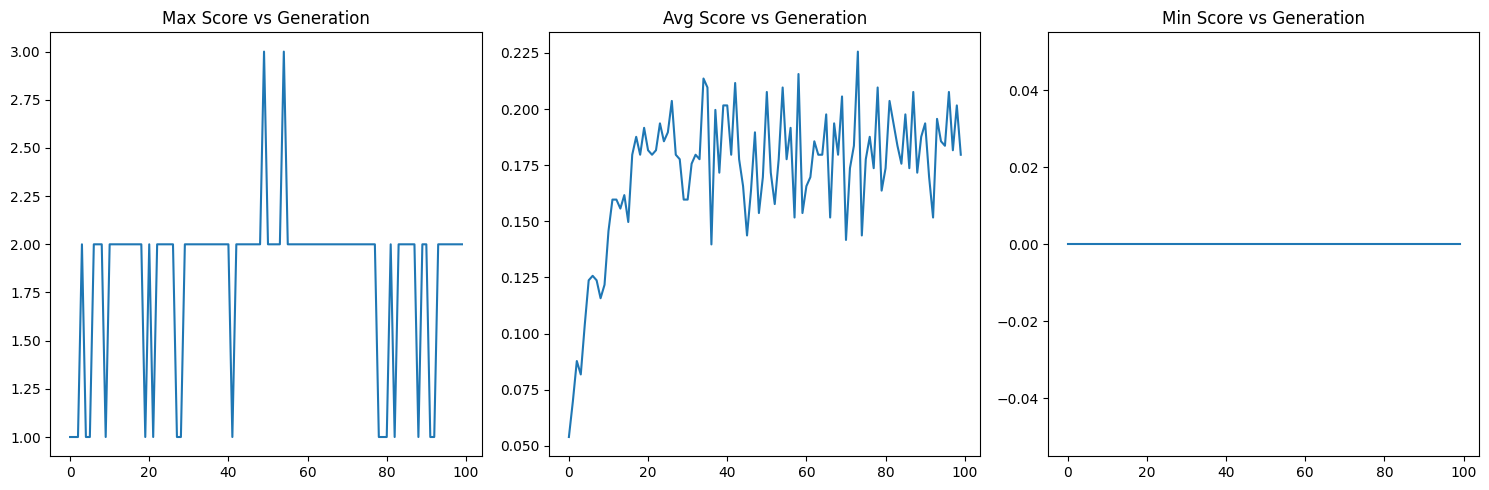

In [39]:
from tqdm import tqdm

class Config:
    def __init__(self):
        
        # simulation params
        self.population_size = 500
        self.num_generations = 100
        self.survival_threshold = 0.2
        self.max_episode_length = 10000
        
        # genome params
        self.num_inputs = 4
        self.num_outputs = 4
        self.kFitnessNotComputed = 0
        
        # structural mutation params
        self.prob_add_link = 0.5
        self.prob_remove_link = 0.5
        self.prob_add_neuron = 0.5
        self.prob_remove_neuron = 0.5

        # non structural mutation params
        self.init_mean = 0.0
        self.init_stdev = 1.0
        self.min = -20.0
        self.max = 20.0
        self.mutation_rate = 0.1
        self.mutate_power = 1.2
        self.replace_rate = 0.05
        
    def compute_fitness(self, individuals) -> Dict:
        
        scores = []
        lens = []
        
        for individual in individuals:
            
            env = SnakeEnv()
            obs = env.reset()
            done = False
            
            graph = Graph(individual.genome)
            score = 0
    
            for i in range(self.max_episode_length):
            
                outputs = graph.forward(obs)
                action = np.argmax(outputs)
                obs, reward, done, info = env.step(action)
                score += reward
                
                if done:
                    break
                    
            individual.fitness = score
            scores.append(score)
            lens.append(i)
            
        return {
            "scores": scores,
            "episode_lengths": lens,
            "avg_scores": sum(scores)/len(scores),
            "max_scores": max(scores),
            "min_scores": min(scores)
        }
        
pool = Population(Config())
winner = pool.run()
pool.plot()

In [40]:
# genome = Population(Config()).new_genome()

# env = SnakeEnv()
# obs = env.reset()
# done = False
# scores = []

# graph = Graph(genome)

# # for _ in range(10000):
# score = 0
# while not done:

#     outputs = graph.forward(obs)
#     action = np.argmax(outputs)
#     obs, reward, done, info = env.step(action)
#     score += reward
# #     scores.append(score)
# # sum(scores)
#     env.render()